In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\Joaquín Amat\\Documents\\GitHub\\skforecast'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# set theme for matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression   
from sklearn.ensemble import RandomForestRegressor
from lineartree import LinearForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skforecast.preprocessing import TimeSeriesDifferentiator
from skforecast.model_selection import backtesting_forecaster

# Data

Train dates : 1991-07-01 00:00:00 --- 2003-03-01 00:00:00  (n=141)
Test dates  : 2003-04-01 00:00:00 --- 2008-06-01 00:00:00  (n=63)


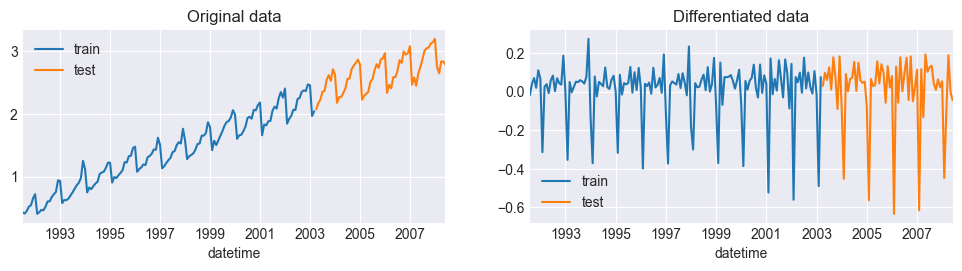

In [3]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o.csv'
)
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Add a smooth positive trend
# ==============================================================================
t = np.arange(len(data))
data = data + 0.01 * t

# Data differentiated
# ==============================================================================
diferenciator = TimeSeriesDifferentiator(order=1)
data_diff = diferenciator.fit_transform(data)
data_diff = pd.Series(data_diff, index=data.index).dropna()

# Data partition train-test
# ==============================================================================
end_train = '2003-03-01 23:59:00'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, axs = plt.subplots(1, 2, figsize=(12, 2.5))
axs = axs.ravel()
data.loc[:end_train].plot(ax=axs[0], label='train')
data.loc[end_train:].plot(ax=axs[0], label='test')
axs[0].legend()
axs[0].set_title('Original data')

data_diff.loc[:end_train].plot(ax=axs[1], label='train')
data_diff.loc[end_train:].plot(ax=axs[1], label='test')
axs[1].legend()
axs[1].set_title('Differentiated data');

# Compare regressors

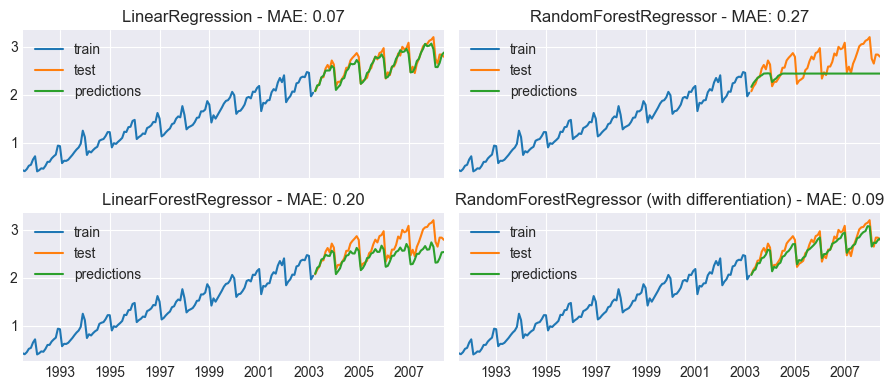

In [4]:
# Compare predictions of different models
# ==============================================================================
regressors = [
    LinearRegression(),
    RandomForestRegressor(random_state=963),
    LinearForestRegressor(base_estimator=LinearRegression(), max_features='sqrt')
]
steps = len(data.loc[end_train:])

fig, ax = plt.subplots(2, 2, figsize=(9, 4), sharex=True, sharey=True)
ax = ax.ravel()
# ForecasterAutoreg
for i, regressor in enumerate(regressors):
    forecaster = ForecasterAutoreg(
        regressor=regressor,
        lags=15
    )
    forecaster.fit(y=data.loc[:end_train])
    predictions = forecaster.predict(steps=steps)
    error = mean_absolute_error(data.loc[end_train:], predictions)
    data.loc[:end_train].plot(ax=ax[i], label='train')
    data.loc[end_train:].plot(ax=ax[i], label='test')
    predictions.plot(ax=ax[i], label='predictions')
    ax[i].set_title(
        f'{forecaster.regressor.__class__.__name__} - MAE: {error:.2f}',
        size=12
    )
    ax[i].set_xlabel('')
    ax[i].legend()

# ForecasterAutoreg with random forest regressor and differentiation
forecaster = ForecasterAutoreg(
                 regressor       = RandomForestRegressor(random_state=963),
                 lags            = 15,
                 differentiation = 1
            )
forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=steps)
error = mean_absolute_error(data.loc[end_train:], predictions)
data.loc[:end_train].plot(ax=ax[3], label='train')
data.loc[end_train:].plot(ax=ax[3], label='test')
predictions.plot(ax=ax[3], label='predictions')
ax[3].set_title(
        f'{forecaster.regressor.__class__.__name__} (with differentiation) - MAE: {error:.2f}',
        size=12
    )
ax[3].set_xlabel('')
ax[3].legend()

fig.tight_layout()

# Validation: differentiation before training or during the training

## Predict

Series differentiated before training
-------------------------------------
Last window of training series: datetime
2002-01-01    0.143554
2002-02-01   -0.560283
2002-03-01    0.075580
2002-04-01    0.048697
2002-05-01    0.098076
2002-06-01   -0.005842
2002-07-01    0.175968
2002-08-01    0.016304
2002-09-01    0.098830
2002-10-01    0.023778
2002-11-01   -0.010180
2002-12-01    0.105980
2003-01-01   -0.014631
2003-02-01   -0.489849
2003-03-01    0.075037
Freq: MS, dtype: float64
Train matrix


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-11-01,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253,-0.018889
1992-12-01,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253
1993-01-01,0.186034,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384


Predictions


2003-04-01    0.017092
2003-05-01    0.085509
2003-06-01    0.030617
2003-07-01    0.127380
2003-08-01    0.001914
                ...   
2008-02-01   -0.419348
2008-03-01    0.081277
2008-04-01   -0.008556
2008-05-01    0.062505
2008-06-01    0.032060
Freq: MS, Name: pred, Length: 63, dtype: float64

2003-04-01    2.060425
2003-05-01    2.145934
2003-06-01    2.176551
2003-07-01    2.303930
2003-08-01    2.305844
                ...   
2008-02-01    2.651466
2008-03-01    2.732743
2008-04-01    2.724187
2008-05-01    2.786692
2008-06-01    2.818752
Length: 63, dtype: float64


Series differentiated during training
-------------------------------------
Last window of training series: datetime
2001-12-01    2.262313
2002-01-01    2.405868
2002-02-01    1.845584
2002-03-01    1.921165
2002-04-01    1.969862
2002-05-01    2.067938
2002-06-01    2.062096
2002-07-01    2.238064
2002-08-01    2.254368
2002-09-01    2.353198
2002-10-01    2.376976
2002-11-01    2.366796
2002-12-01    2.472776
2003-01-01    2.458145
2003-02-01    1.968296
2003-03-01    2.043333
Freq: MS, Name: y, dtype: float64
Train matrix


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-11-01,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253,-0.018889
1992-12-01,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253
1993-01-01,0.186034,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384


Predictions


2003-04-01    2.060425
2003-05-01    2.145934
2003-06-01    2.176551
2003-07-01    2.303930
2003-08-01    2.305844
                ...   
2008-02-01    2.651466
2008-03-01    2.732743
2008-04-01    2.724187
2008-05-01    2.786692
2008-06-01    2.818752
Freq: MS, Name: pred, Length: 63, dtype: float64

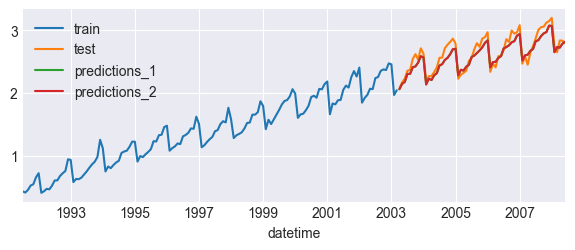

In [5]:
# Comparasion of results if the time series is differentiated before training or during the training
# =================================================================================================
print("Series differentiated before training")
print("-------------------------------------")
forecaster_1 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )

forecaster_1.fit(y=data_diff.loc[:end_train])
last_window_1 = forecaster_1.last_window
print(f"Last window of training series: {last_window_1}")
print("Train matrix")
X_train_1, y_train_1 = forecaster_1.create_train_X_y(data_diff.loc[:end_train])
display(X_train_1.head(3))
predictions_diff = forecaster_1.predict(steps=steps)
last_value_train = data.loc[:end_train].iloc[[-1]]
predictions_1 = pd.concat([last_value_train, predictions_diff]).cumsum()[1:]
print("Predictions")
display(predictions_diff)
display(predictions_1)
print("")

print("Series differentiated during training")
print("-------------------------------------")
forecaster_2 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 differentiation = 1
             )

forecaster_2.fit(y=data.loc[:end_train])
last_window_2 = forecaster_2.last_window
print(f"Last window of training series: {last_window_2}")
print("Train matrix")
X_train_2, y_train_2 = forecaster_2.create_train_X_y(data.loc[:end_train])
display(X_train_2.head(3))
predictions_2 = forecaster_2.predict(steps=steps)
print("Predictions")
display(predictions_2)

fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_1.plot(ax=ax, label='predictions_1')
predictions_2.plot(ax=ax, label='predictions_2')
ax.legend();


In [6]:
pd.testing.assert_frame_equal(X_train_1, X_train_2, check_names=True)
pd.testing.assert_frame_equal(forecaster_1.get_feature_importances(), forecaster_2.get_feature_importances(), check_names=True)
pd.testing.assert_series_equal(predictions_1.asfreq('MS'), predictions_2, check_names=False)

## Bootstrapping

In [7]:
# Compare bootstrapping prediction if the time series is differenciated before training or during the training
# =================================================================================================
print("Series differentiated before training")
print("-------------------------------------")
forecaster_1 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )

forecaster_1.fit(y=data_diff.loc[:end_train])
boot_predictions_diff = forecaster_1.predict_bootstrapping(
                            steps=steps,
                            n_boot=10
                        )
last_value_train = data.loc[:end_train].iloc[[-1]]

boot_predictions_1 = boot_predictions_diff.copy()
boot_predictions_1.loc[last_value_train.index[0]] = last_value_train.values[0]
boot_predictions_1 = boot_predictions_1.sort_index()
boot_predictions_1 = boot_predictions_1.cumsum(axis=0).iloc[1:,]
boot_predictions_1 = boot_predictions_1.asfreq('MS')

print("Predictions")
display(boot_predictions_diff.head(3))
print("Predictions undifferentiated")
display(boot_predictions_1.head(3))
print("")

print("Series differentiated during training")
print("-------------------------------------")
forecaster_2 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 differentiation = 1
               )

forecaster_2.fit(y=data.loc[:end_train])
boot_predictions_2 = forecaster_2.predict_bootstrapping(
                        steps=steps,
                        n_boot=10
                     )
print("Predictions")
display(boot_predictions_2.head(3))

Series differentiated before training
-------------------------------------
Predictions


,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9
2003-04-01,0.030295,0.032775,-0.002842,0.014901,0.043229,0.001341,0.001325,0.010020,0.040975,0.019096
2003-05-01,0.060069,0.053095,0.082596,0.083665,0.070504,0.086381,0.066698,0.084330,0.087346,0.109301
2003-06-01,0.046608,0.036182,0.037772,0.054342,0.025494,0.037961,0.060449,0.040089,0.022522,0.021476


Predictions undifferentiated


,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9
2003-04-01,2.073628,2.076108,2.040491,2.058234,2.086562,2.044674,2.044659,2.053353,2.084308,2.062429
2003-05-01,2.133696,2.129204,2.123086,2.141899,2.157067,2.131055,2.111357,2.137683,2.171655,2.171730
2003-06-01,2.180305,2.165386,2.160859,2.196241,2.182561,2.169016,2.171806,2.177772,2.194176,2.193207



Series differentiated during training
-------------------------------------
Predictions


,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9
2003-04-01,2.073628,2.076108,2.040491,2.058234,2.086562,2.044674,2.044659,2.053353,2.084308,2.062429
2003-05-01,2.133696,2.129204,2.123086,2.141899,2.157067,2.131055,2.111357,2.137683,2.171655,2.171730
2003-06-01,2.180305,2.165386,2.160859,2.196241,2.182561,2.169016,2.171806,2.177772,2.194176,2.193207


In [8]:
pd.testing.assert_frame_equal(boot_predictions_1, boot_predictions_2)

## Backtesting

In [9]:
# Backtesting
# ==============================================================================
steps = 5
forecaster_1 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )
_, predictions_1 = backtesting_forecaster(
                          forecaster            = forecaster_1,
                          y                     = data_diff,
                          steps                 = steps,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data_diff.loc[:end_train]),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True  
                      )

# Revert differentiation of predictions
# Predictions of each fold must be reverted individually.
predictions_1 = predictions_1.rename(columns={'pred': 'pred_diff'})
folds = len(predictions_1) / steps
folds = int(np.ceil(folds))
predictions_1['backtesting_fold_id'] = np.repeat(range(folds), steps)[:len(predictions_1)]

# Add the previous observed value of the time series (only to the first prediction of each fold)
previous_overved_values = data.shift(1).loc[predictions_1.index].iloc[::steps]
previous_overved_values.name = 'previous_overved_value'
predictions_1 = predictions_1.merge(previous_overved_values, left_index=True, right_index=True, how='left')
predictions_1 = predictions_1.fillna(0)
predictions_1['summed_value'] = predictions_1['pred_diff'] + predictions_1['previous_overved_value']
# Revert differentiation with the cumulative sum
predictions_1['pred'] = predictions_1.groupby('backtesting_fold_id').apply(lambda x: x['summed_value'].cumsum()).to_numpy()


forecaster_2 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 differentiation=1
             )
_, predictions_2 = backtesting_forecaster(
                          forecaster            = forecaster_2,
                          y                     = data,
                          steps                 = steps,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data.loc[:end_train]),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = True,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True  
                      )


results = pd.concat((predictions_1['pred'], predictions_2['pred']), axis=1)
results.columns = ['pred_1', 'pred_2']
results['equal'] = np.isclose(results['pred_1'], results['pred_2'])
results.head(15)

  0%|          | 0/13 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 140
    First 1 observation/s in training sets are used for differentiation
Number of observations used for backtesting: 63
    Number of folds: 13
    Number of steps per fold: 5
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   1991-08-01 00:00:00 -- 2003-03-01 00:00:00  (n=140)
    Validation: 2003-04-01 00:00:00 -- 2003-08-01 00:00:00  (n=5)
Fold: 1
    Training:   1991-08-01 00:00:00 -- 2003-08-01 00:00:00  (n=145)
    Validation: 2003-09-01 00:00:00 -- 2004-01-01 00:00:00  (n=5)
Fold: 2
    Training:   1991-08-01 00:00:00 -- 2004-01-01 00:00:00  (n=150)
    Validation: 2004-02-01 00:00:00 -- 2004-06-01 00:00:00  (n=5)
Fold: 3
    Training:   1991-08-01 00:00:00 -- 2004-06-01 00:00:00  (n=155)
    Validation: 2004-07-01 00:00:00 -- 2004-11-01 00:00:00  (n=5)
Fold

  0%|          | 0/13 [00:00<?, ?it/s]

,pred_1,pred_2,equal
2003-04-01,2.060425,2.060425,True
2003-05-01,2.145934,2.145934,True
2003-06-01,2.176551,2.176551,True
2003-07-01,2.303930,2.303930,True
2003-08-01,2.305844,2.305844,True
2003-09-01,2.471311,2.471311,True
2003-10-01,2.476730,2.476730,True
2003-11-01,2.521333,2.521333,True
2003-12-01,2.626338,2.626338,True
2004-01-01,2.590535,2.590535,True


In [10]:
pd.testing.assert_series_equal(predictions_1['pred'], predictions_2['pred'])

# Comapare ARIMA vs ForecasterAutoreg with diff

Predictions Sarimax


2003-04-01    2.082169
2003-05-01    2.157004
2003-06-01    2.166180
2003-07-01    2.311923
Freq: MS, Name: predicted_mean, dtype: float64

Predictions Forecaster


2003-04-01    2.111058
2003-05-01    2.209295
2003-06-01    2.229781
2003-07-01    2.392288
Freq: MS, Name: pred, dtype: float64

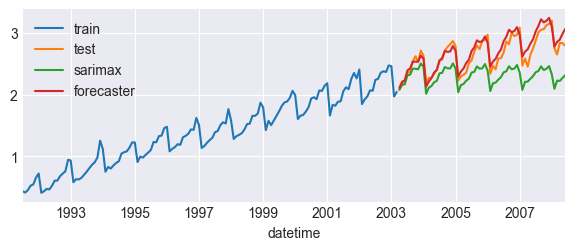

In [11]:
# Compare predictions with an arima (lags, 1, 0)
# ==============================================================================
from statsmodels.tsa.statespace.sarimax import SARIMAX
steps = len(data.loc[end_train:])

sarimax = SARIMAX(data.loc[:end_train], order=(12, 1, 0))
res_sarimax = sarimax.fit(disp=False, maxiter=1000)
predictions_sarimax = res_sarimax.get_forecast(steps).predicted_mean
print("Predictions Sarimax")
display(predictions_sarimax.head(4))

forecaster = ForecasterAutoreg(
                 regressor       = LinearRegression(),
                 lags            = 12,
                 differentiation = 1
            )
            
forecaster.fit(y=data.loc[:end_train])
print("Predictions Forecaster")
predictions = forecaster.predict(steps=steps)
display(predictions.head(4))

fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_sarimax.plot(ax=ax, label='sarimax')
predictions.plot(ax=ax, label='forecaster')
ax.legend();